Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

In [1]:
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway # ANOVA test

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [2]:
def print_missing_values(column):
    print(f"Missing values in the {column.name} column: {column.isna().sum()}, or {column.isna().sum()/len(column)*100:.2f}% of the dataset")

## Data preparation

In [3]:
# load the data
try:
    df = pd.read_csv('data/car_data.csv')
except:
    df = pd.read_csv('/datasets/car_data.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
df.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
200086,14/03/2016 21:37,11200,sedan,2008,manual,170,1er,90000,6,petrol,bmw,no,14/03/2016 00:00,0,97440,06/04/2016 11:46
65040,03/04/2016 10:56,18750,convertible,1980,manual,126,spider,40000,5,petrol,alfa_romeo,no,03/04/2016 00:00,0,30966,05/04/2016 09:51
120682,15/03/2016 11:36,300,coupe,1993,manual,71,astra,5000,9,petrol,opel,NaN,15/03/2016 00:00,0,41836,31/03/2016 07:17
291575,29/03/2016 13:45,950,small,1996,manual,60,corsa,150000,0,petrol,opel,no,29/03/2016 00:00,0,47906,05/04/2016 22:47
179578,20/03/2016 22:52,2250,bus,1997,manual,102,sprinter,150000,6,gasoline,mercedes_benz,no,20/03/2016 00:00,0,63110,21/03/2016 00:46


In [6]:
# Full duplicate count
print(f'Full duplicates: {df.duplicated().sum()}, or {df.duplicated().sum()/len(df)*100:.2f}% of the dataset')

# Delete duplicates
df.drop_duplicates(inplace=True)

print(f'Full duplicates: {df.duplicated().sum()}, or {df.duplicated().sum()/len(df)*100:.2f}% of the dataset')

Full duplicates: 262, or 0.07% of the dataset
Full duplicates: 0, or 0.00% of the dataset


In [7]:
# Let's rearrange the columns in a more logical order
df = df[['DateCrawled',
         'DateCreated',
         'LastSeen',
         'Brand',
         'Model',
         'VehicleType',
         'Gearbox',
         'Power',
         'Mileage',
         'FuelType',
         'NotRepaired',
         'RegistrationMonth',
         'RegistrationYear',
         'PostalCode',
         'NumberOfPictures',
         'Price']]

len(df.columns)

16

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354107 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354107 non-null  object
 1   DateCreated        354107 non-null  object
 2   LastSeen           354107 non-null  object
 3   Brand              354107 non-null  object
 4   Model              334406 non-null  object
 5   VehicleType        316623 non-null  object
 6   Gearbox            334277 non-null  object
 7   Power              354107 non-null  int64 
 8   Mileage            354107 non-null  int64 
 9   FuelType           321218 non-null  object
 10  NotRepaired        282962 non-null  object
 11  RegistrationMonth  354107 non-null  int64 
 12  RegistrationYear   354107 non-null  int64 
 13  PostalCode         354107 non-null  int64 
 14  NumberOfPictures   354107 non-null  int64 
 15  Price              354107 non-null  int64 
dtypes: int64(7), object(9)
me

None of the date columns (`DateCrawled`, `DateCreated`, `LastSeen`) should be used for training since the data is not available at time of prediction. Let's go ahead and drop them.

In [9]:
df.drop(['DateCrawled', 'DateCreated', 'LastSeen'], axis=1, inplace=True)

### Brand Column

In [10]:
print_missing_values(df['Brand'])
df['Brand'].value_counts().sort_index() # sort by alphabetical order

Missing values in the Brand column: 0, or 0.00% of the dataset


Brand
alfa_romeo         2311
audi              29439
bmw               36881
chevrolet          1751
chrysler           1439
citroen            5143
dacia               898
daewoo              542
daihatsu            806
fiat               9634
ford              25163
honda              2817
hyundai            3583
jaguar              505
jeep                677
kia                2463
lada                225
lancia              471
land_rover          545
mazda              5611
mercedes_benz     32025
mini               3201
mitsubishi         3022
nissan             4936
opel              39902
peugeot           10988
porsche             758
renault           17915
rover               486
saab                526
seat               6901
skoda              5490
smart              5241
sonstige_autos     3373
subaru              762
suzuki             2320
toyota             4601
trabant             589
volkswagen        76960
volvo              3207
Name: count, dtype: int64

No missing or unexpected values in the `Brand` column.

### Model Column

In [11]:
print_missing_values(df['Model'])
print(sorted([str(x) for x in df['Model'].unique().tolist()])) # sort by alphabetical order with handling of NaN

Missing values in the Model column: 19701, or 5.56% of the dataset
['100', '145', '147', '156', '159', '1_reihe', '1er', '200', '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe', '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma', 'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo', 'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma', 'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery', 'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos', 'escort', 'espace', 'exeo', 'fabia', 'fiesta', 'focus

In [12]:
# There are NaN values, but also values labeled as 'other'. We will combine these into the 'unknown' category since both are a type of catch-all for unknown values.

df['Model'].fillna('unknown', inplace=True) # fill NaN values with 'unknown'
df['Model'].replace('other', 'unknown', inplace=True) # replace 'other' with 'unknown'

In [13]:
print_missing_values(df['Model'])
print()
print(sorted(df['Model'].unique().tolist())) # sort by alphabetical order

# Print number of unique values in the 'Model' column
print(f"\nNumber of unique values in the 'Model' column: {df['Model'].nunique()}")

Missing values in the Model column: 0, or 0.00% of the dataset

['100', '145', '147', '156', '159', '1_reihe', '1er', '200', '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe', '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma', 'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo', 'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma', 'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery', 'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos', 'escort', 'espace', 'exeo', 'fabia', 'fiesta', 'focus', 

Unfortunately, the significant number of unique values in the model column is causing computational demand beyond what we have available to us. In order to mitigate this we will choose a threshold for top n popular models, and collapse the rest into the 'unknown' label.

In [14]:
def consolidate_models(df, threshold):
    # Make list of top n model counts ordered by count excluding 'unknown' values
    model_counts = df['Model'].value_counts().sort_values(ascending=False).drop('unknown').head(threshold).index.tolist()
       
    # Replace all models not in the top n with 'unknown'
    df.loc[~df['Model'].isin(model_counts), 'Model'] = 'unknown'
    
    return df

df = consolidate_models(df, 200)

# Print number of unique values in the 'Model' column
print(f"Number of unique values in the 'Model' column: {df['Model'].nunique()}")

Number of unique values in the 'Model' column: 201


### VehicleType Column

In [15]:
print_missing_values(df['VehicleType'])

Missing values in the VehicleType column: 37484, or 10.59% of the dataset


In [16]:
# display df where missing values are present in the VehicleType column
display(df[df['VehicleType'].isnull()].head())

,Brand,Model,VehicleType,Gearbox,Power,Mileage,FuelType,NotRepaired,RegistrationMonth,RegistrationYear,PostalCode,NumberOfPictures,Price
0,volkswagen,golf,NaN,manual,0,150000,petrol,NaN,0,1993,70435,0,480
16,volkswagen,polo,NaN,NaN,60,150000,petrol,NaN,0,2016,38871,0,300
22,opel,meriva,NaN,manual,90,150000,petrol,no,5,2018,49716,0,2900
26,citroen,c4,NaN,manual,125,125000,NaN,no,4,2017,31139,0,5555
31,renault,clio,NaN,manual,60,150000,petrol,NaN,6,2016,37075,0,899


In [17]:
# Q: Is it possible to pull the `VehicleType` from other rows by matching the `Brand` and `Model` columns?

def investigate():
    # Group by Brand and Model and count the number of unique VehicleTypes
    df_brand_model = df.groupby(['Brand', 'Model'])['VehicleType'].nunique().reset_index()
    print(f"Total Brand Model combinations: {df_brand_model.shape[0]}")

    print()
    print('Brand, Model combinations with one VehicleType:')
    print(df_brand_model[df_brand_model['VehicleType'] == 1])
    print(f"row count: {df_brand_model[df_brand_model['VehicleType'] == 1].shape[0]}")
    

investigate()


Total Brand Model combinations: 247

Brand, Model combinations with one VehicleType:
          Brand       Model  VehicleType
27    chevrolet     captiva            1
87         jeep    cherokee            1
177       rover  freelander            1
222  volkswagen         eos            1
229  volkswagen     phaeton            1
241       volvo         s60            1
row count: 6


I was hoping I could reliably pull the `VehicleType` from other rows by matching the `Brand` and `Model` columns, but it looks like relatively few instances of the Brand / Model combination result in only one vehicle type.  

We will convert this to 'unknown', as well as convert 'other' to 'unknown' for the same reason as in the `Brand` column.

In [18]:
df['VehicleType'].value_counts()

VehicleType
sedan          91399
small          79753
wagon          65115
bus            28752
convertible    20180
coupe          16147
suv            11991
other           3286
Name: count, dtype: int64

In [19]:
# Fill missing values with 'unkown'
df['VehicleType'].fillna('unknown', inplace=True)

# Replace 'other' with 'unknown'
df['VehicleType'].replace('other', 'unknown', inplace=True)

print_missing_values(df['VehicleType'])

df['VehicleType'].value_counts()

# Assert there are no rows where both Brand and Model are 'unknown'
assert len(df[(df['Brand'] == 'unknown') & (df['Model'] == 'unknown')]) == 0, 'There are rows where both Brand and Model are unknown'

Missing values in the VehicleType column: 0, or 0.00% of the dataset


### Missing Values - Gearbox

In [20]:
print_missing_values(df['Gearbox'])
print(df['Gearbox'].value_counts())

Missing values in the Gearbox column: 19830, or 5.60% of the dataset
Gearbox
manual    268034
auto       66243
Name: count, dtype: int64


There is no reliable way to deduce or guess what Gearbox value should be for missing values, so we simply fill in with 'unknown'.

In [21]:
# Fill missing values with 'unknown'
df['Gearbox'].fillna('unknown', inplace=True)

print_missing_values(df['Gearbox'])
print(df['Gearbox'].value_counts())

Missing values in the Gearbox column: 0, or 0.00% of the dataset
Gearbox
manual     268034
auto        66243
unknown     19830
Name: count, dtype: int64


### Power Column

In [22]:
print_missing_values(df['Power'])
print(df['Power'].describe())

Missing values in the Power column: 0, or 0.00% of the dataset
count    354107.000000
mean        110.089651
std         189.914972
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64


There are no missing values, but there are some outliers that seem to be impossible. I don't think there are cars with 0 or 20,000 horsepower. I did some research on horsepower and came away with this:
> "A normal city car might have 90 horsepower, a family hatchback could have 140 horsepower, and midsize cars can have around 200 horsepower. Cars with more than 300 horsepower are usually performance vehicles, and modern supercars can have over 500 horsepower."

In [23]:
# How many rows have a power of 0?
print(f"Rows with a power of 0: {df[df['Power'] == 0].shape[0]}, or {df[df['Power'] == 0].shape[0]/len(df)*100:.2f}% of the dataset")

Rows with a power of 0: 40218, or 11.36% of the dataset


In [24]:
# How many rows have a power of less than 50?
print(f"Rows with a power of less than 50: {df[df['Power'] < 50].shape[0]}, or {df[df['Power'] < 50].shape[0]/len(df)*100:.2f}% of the dataset")

Rows with a power of less than 50: 46164, or 13.04% of the dataset


In [25]:
# How many rows have a power of greater than 600?
print(f"Rows with a power greater than 600: {df[df['Power'] > 600].shape[0]}, or {df[df['Power'] > 500].shape[0]/len(df)*100:.2f}% of the dataset")

Rows with a power greater than 600: 384, or 0.13% of the dataset


Obviously this is a lot of data that we don't want to lose. Let's start by making a filtered df containing only horsepower values within the range (50, 600). Then calculate the average horsepower per brand, model, fueltype combination - I believe these three categories are most indicative of horsepower. 

In [26]:
def clean_power_column():
    # Create a filtered df where Power is between 50 and 600, I don't want the outliers to affect the mean
    filtered_df = df[(df['Power'] >= 50) & (df['Power'] <= 600)]
    
    # Calculate the mean power (as int) grouped by Brand, Model, FuelType
    mean_power_df = filtered_df.groupby(['Brand', 'Model', 'FuelType'])['Power'].mean().round(0).astype(int).reset_index()
    
    # Merge the mean power column with the original df
    merged_df = pd.merge(df, mean_power_df, on=['Brand', 'Model', 'FuelType'], suffixes=('', '_mean'))
    
    # Apply a lambda function to fill values less than 50 and greater than 600 with the mean power
    merged_df['Power'] = merged_df.apply(lambda x: x['Power_mean'] if x['Power'] < 50 or x['Power'] > 600 else x['Power'], axis=1)
    
    # Drop the mean power column
    merged_df.drop('Power_mean', axis=1, inplace=True)
    
    return merged_df

df = clean_power_column()

In [27]:
# Describe the Power column again after cleaning
print(df['Power'].describe())

count    321107.000000
mean        120.773032
std          52.173836
min          50.000000
25%          80.000000
50%         111.000000
75%         150.000000
max         600.000000
Name: Power, dtype: float64


Text(0.5, 1.0, 'Horsepower Distribution')

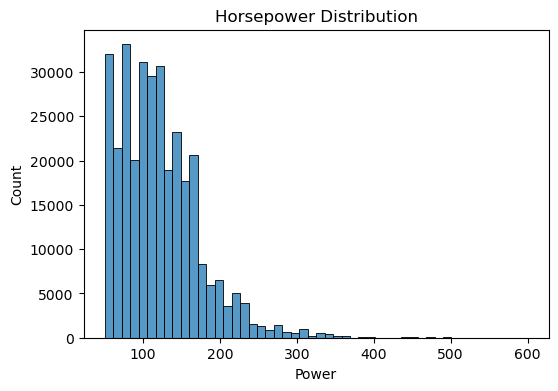

In [28]:
# Let's look at the distribution of the Power column
plt.figure(figsize=(6, 4))
sns.histplot(df['Power'], bins=50)
plt.title('Horsepower Distribution')

This is a much more plausible range for horsepower.

### Milage Column

In [29]:
print_missing_values(df['Mileage'])
print(df['Mileage'].describe())

Missing values in the Mileage column: 0, or 0.00% of the dataset
count    321107.000000
mean     128436.082054
std       37052.327825
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Mileage, dtype: float64


In [30]:
# Check if converting the Mileage column to int will result in any loss of data using np equal
if np.array_equal(df['Mileage'], df['Mileage'].astype(int)):
    # Convert the Mileage column to int
    df['Mileage'] = df['Mileage'].astype(int)
else:
    raise ValueError('Conversion to int will result in data loss')

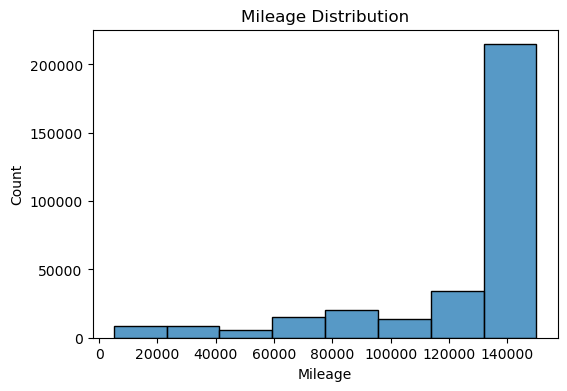

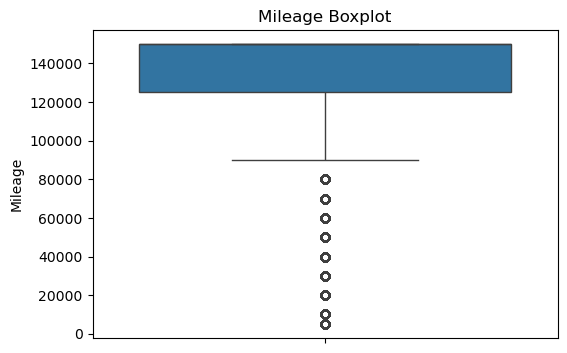

In [31]:
# Plot the distribution of the Mileage column
plt.figure(figsize=(6, 4))
sns.histplot(df['Mileage'], bins=8)
plt.title('Mileage Distribution')
plt.show()

# Boxplot of Mileage
plt.figure(figsize=(6, 4))
sns.boxplot(y='Mileage', data=df)
plt.title('Mileage Boxplot')
plt.show()

There are no missing values or extreme outliers in the `Mileage` column. The distribution is heavily left skewed, with the majority of the data near the max value. This makes sense considering our data source (used cars), but we may need to do some balancing when it comes time to train our models.

### Fuel Type Column

In [32]:
print_missing_values(df['FuelType'])
print(df['FuelType'].value_counts())

Missing values in the FuelType column: 0, or 0.00% of the dataset
FuelType
petrol      216161
gasoline     98646
lpg           5303
cng            556
hybrid         226
other          129
electric        86
Name: count, dtype: int64


No missing values in `FuelType` and we see a plausible value counts.

### Not Repaired Column

In [33]:
print_missing_values(df['NotRepaired'])
print(df['NotRepaired'].value_counts())

Missing values in the NotRepaired column: 54520, or 16.98% of the dataset
NotRepaired
no     234487
yes     32100
Name: count, dtype: int64


In [34]:
# There is no reliable way to fill the missing values in the NotRepaired column, so we will fill them with 'unknown'
df['NotRepaired'].fillna('unknown', inplace=True)

# I also find this column  name to be a bit confusing, so I will rename it to 'RepairedStatus'
df.rename(columns={'NotRepaired': 'RepairedStatus'}, inplace=True)

print_missing_values(df['RepairedStatus'])
print(df['RepairedStatus'].value_counts())

Missing values in the RepairedStatus column: 0, or 0.00% of the dataset
RepairedStatus
no         234487
unknown     54520
yes         32100
Name: count, dtype: int64


### Registration Month Column

In [35]:
print_missing_values(df['RegistrationMonth'])
print(df['RegistrationMonth'].value_counts().sort_index())

# Count and percentage of rows with a registration month of 0
print()
print(f"Rows with a registration month of 0: {df[df['RegistrationMonth'] == 0].shape[0]}, or {df[df['RegistrationMonth'] == 0].shape[0]/len(df)*100:.2f}% of the dataset")

Missing values in the RegistrationMonth column: 0, or 0.00% of the dataset
RegistrationMonth
0     23685
1     21667
2     19986
3     32460
4     27451
5     27170
6     29379
7     25544
8     21183
9     22465
10    24616
11    22793
12    22708
Name: count, dtype: int64

Rows with a registration month of 0: 23685, or 7.38% of the dataset


Hmm... there are 13 month values...

Management has advised that month 0 represents unknown month. We don't want to drop these rows however because they are too large a portion of the dataset.  

Instead we will convert 0 to 'unknown' and treat the entire column as categorical.

In [36]:
# Convert to string
df['RegistrationMonth'] = df['RegistrationMonth'].astype(str)

# Replace 0 with 'unknown'
df['RegistrationMonth'].replace('0', 'unknown', inplace=True)

# Make type categorical
df['RegistrationMonth'] = df['RegistrationMonth'].astype('category')

# Value counts
print(df['RegistrationMonth'].value_counts())

RegistrationMonth
3          32460
6          29379
4          27451
5          27170
7          25544
10         24616
unknown    23685
11         22793
12         22708
9          22465
1          21667
8          21183
2          19986
Name: count, dtype: int64


### Registration Year Column

In [37]:
print_missing_values(df['RegistrationYear'])
print(df['RegistrationYear'].describe())

Missing values in the RegistrationYear column: 0, or 0.00% of the dataset
count    321107.000000
mean       2003.306599
std          40.891050
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        9999.000000
Name: RegistrationYear, dtype: float64


In [38]:
# Check if converting the RegistrationYear column to int will result in any loss of data using np equal
if np.array_equal(df['RegistrationYear'], df['RegistrationYear'].astype(int)):
    # Convert the RegistrationYear column to int
    df['RegistrationYear'] = df['RegistrationYear'].astype(int)
else:
    raise ValueError('Conversion to int will result in data loss')

I know I will drop the min and max values since they are impossible, but lets investigate to see if we can find a plausible minimum value.

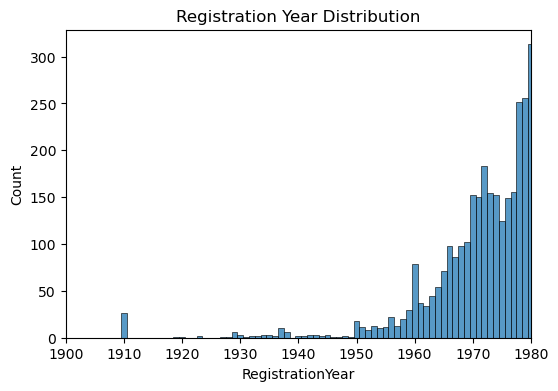

In [39]:
# Plot the distribution of the RegistrationYear column with adjustable range
def plot_registration_year_distribution(min_year, max_year):
    plt.figure(figsize=(6, 4))
    sns.histplot(df['RegistrationYear'][(df['RegistrationYear'] <= max_year) & (df['RegistrationYear'] > min_year)], bins=max_year-min_year, discrete=True)
    # Keep the x-axis in ints and label
    plt.locator_params(axis='x', integer=True)
    # Set the x-axis range
    plt.xlim(min_year, max_year)

    plt.title('Registration Year Distribution')

    plt.show()
    
plot_registration_year_distribution(1900, 1980)

In [40]:
# What percent of the data is below 1960?
print(f"Rows with a registration year below 1960: {df[df['RegistrationYear'] < 1960].shape[0]}, or {df[df['RegistrationYear'] < 1960].shape[0]/len(df)*100:.2f}% of the dataset")

Rows with a registration year below 1960: 258, or 0.08% of the dataset


There is a small percentage of the data that falls below 1960. I am also considering the unlikelihood of such sales happening, and the change in value of money. For these reasons I feel comfortable dropping any records with a registration date less than 1960.

In [41]:
# Drop rows with a registration year below 1960
df = df[df['RegistrationYear'] >= 1960]

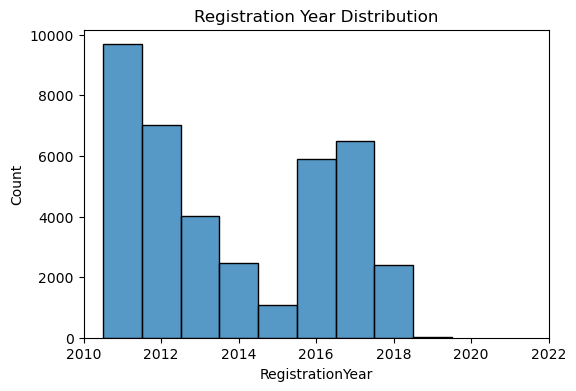

In [42]:
# It should be easier to find the upper limit of plausible registration years
plot_registration_year_distribution(2010, 2022)

In [43]:
# Get the count and percentage of rows with 2019 registration year
print(f"Rows with a registration year of 2019: {df[df['RegistrationYear'] == 2019].shape[0]}, or {df[df['RegistrationYear'] == 2019].shape[0]/len(df)*100:.2f}% of the dataset")

Rows with a registration year of 2019: 14, or 0.00% of the dataset


It looks like the data collection ended in 2019, but with very few records. Let's drop everything after 2018.

Missing values in the RegistrationYear column: 0, or 0.00% of the dataset


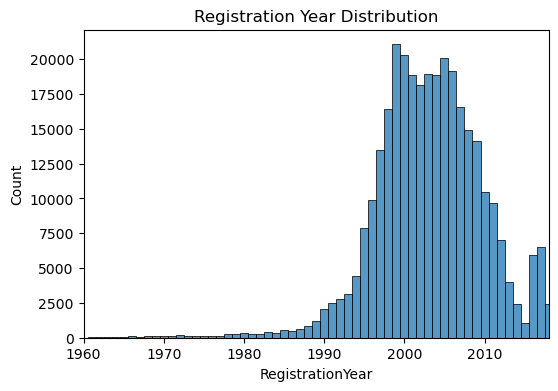

In [44]:
# Drop rows with a registration year of above 2018
df = df[df['RegistrationYear'] <= 2018]

print_missing_values(df['RegistrationYear'])

# Plot the distribution of the RegistrationYear column after cleaning
plot_registration_year_distribution(df['RegistrationYear'].min(), df['RegistrationYear'].max())



Column has been cleaned for model training.

There is an interesting shape to this graph with respect to the dip in sales of cars registered 2010 - 2015, then a sudden jump in 2016 and 2017. It would makes sense that you see less and less sales of newer used cars, but why the jump in 2016 and 2017? 

Interesting question to ask, not sure it has any bearing on the task at hand.

### Postal Code Column

In [45]:
print_missing_values(df['PostalCode'])

print(df['PostalCode'].dtype)

Missing values in the PostalCode column: 0, or 0.00% of the dataset
int64


<div class="alert alert-info"> 
I am at a bit of a cross roads here. On one hand, I can see how using postal codes might cross an ethical line - though, I'm not sure  I could articulate exactly why. On the other hand, I see how postal code could be a valuable feature for price prediction.<br>

First I will test to see if there is indeed a correlation between the postal code and the price.<br>

We need to be sure to treat postal code as a categorical feature, and not a continuous one. In order the test the correlation of postal code to the price, we will use the [ANOVA TEST](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html) from the Scipy.Statistics library.

<center><i>"The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean. The test is applied to samples from two or more groups, possibly with differing sizes."</i></center>

<b>QUESTION FOR REVIEWER:</b> What is your advice for using or not using postal codes in this project if it were a real life scenario? Specifically with regards to ethics and data privacy? 
</div>

Using the full postal code results in over 8,000 unique values, which makes our training data too large the compute available to us for this project. So we will group the postal codes by their first two digits and test for a correlation.

In [46]:
# Convert the PostalCode column to string
df['PostalCode'] = df['PostalCode'].astype(str)

# Keep only the first two characters of the postal code
df['PostalCode'] = df['PostalCode'].str[:2]

F-statistic: 46.66302437734419, p-value: 0.0
Reject the null hypothesis that the means are equal. There is a significant difference between the average prices.

Sample summary statistics for price by postal code:


,median,mean,std,count
PostalCode,,,,
76,3499.0,5038.831912,4640.593443,3165
84,3499.0,5116.104473,4826.286675,3398
54,3100.0,4865.882826,4703.902540,2236
58,2600.0,4361.066512,4479.870370,4315
44,2890.0,4406.399192,4347.903418,6185


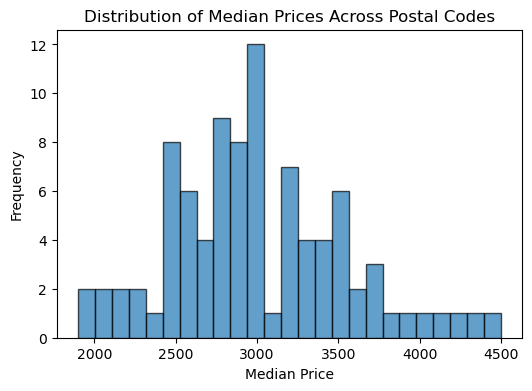

In [47]:
def test_postcode_for_correlation(df):

    # Group data by postal codes and extract lists of prices
    grouped_prices = df.groupby('PostalCode')['Price']
    grouped_prices_list = grouped_prices.apply(list).tolist()
     
    # Perform the ANOVA test
    f_statistic, p_value = f_oneway(*grouped_prices_list)
    
    print(f'F-statistic: {f_statistic}, p-value: {p_value}')
    
    alpha = 0.05
    if p_value < alpha:
        print('Reject the null hypothesis that the means are equal. There is a significant difference between the average prices.')
    else:
        print('Fail to reject the null hypothesis that the means are equal.')
        
    # Calculate summary statistics for price by postal code
    summary_stats = df.groupby('PostalCode')['Price'].agg(['median', 'mean', 'std', 'count'])
    print("\nSample summary statistics for price by postal code:")
    display(summary_stats.sample(5))
    
    # Plot histogram of median prices
    plt.figure(figsize=(6, 4))
    plt.hist(summary_stats['median'], bins=25, edgecolor='k', alpha=0.7)
    plt.title('Distribution of Median Prices Across Postal Codes')
    plt.xlabel('Median Price')
    plt.ylabel('Frequency')
    plt.show()

        
# Call the function
test_postcode_for_correlation(df)

It looks like `PostalCode` has a pretty strong correlation with `Price`. We will convert it to an object type (categorical) and use it for training. Once we find our best model, we can also retrain without the postal code and reassess.

In [48]:
# We already know there are no non-numeric characters in the PostalCode column because it was originally an int column

# Make column categorical
df['PostalCode'] = df['PostalCode'].astype('category')

Even still the features require too much compute. We will drop the PostalCode Column.

In [49]:
# Drop PostalCode column
df.drop('PostalCode', axis=1, inplace=True)

### Number of Pictures Column:

In [50]:
print_missing_values(df['NumberOfPictures'])
print(df['NumberOfPictures'].value_counts())

Missing values in the NumberOfPictures column: 0, or 0.00% of the dataset
NumberOfPictures
0    320807
Name: count, dtype: int64


Since this column only has the value zero for every row, this is not a valuable column for building a machine learning model. We will drop it.

In [51]:
df.drop('NumberOfPictures', axis=1, inplace=True)

### Price Column

In [52]:
print_missing_values(df['Price'])
print(df['Price'].describe())

Missing values in the Price column: 0, or 0.00% of the dataset
count    320807.000000
mean       4627.789799
std        4567.479785
min           0.000000
25%        1200.000000
50%        2950.000000
75%        6700.000000
max       20000.000000
Name: Price, dtype: float64


In [53]:
print(df['Price'][df['Price'] < 500].value_counts().sort_index())

Price
0      7287
1       735
2         9
3         5
5        10
       ... 
489       3
490     193
495      11
498       4
499     535
Name: count, Length: 243, dtype: int64


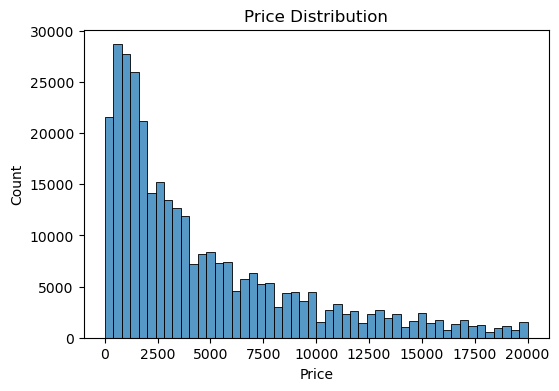

In [54]:
# Plot the distribution of the Price column
plt.figure(figsize=(6, 4))
sns.histplot(df['Price'], bins=50)
plt.title('Price Distribution')
plt.show()

There is a significant right skew to this graph, but that seems to make sense in regard to used car prices. The large amount of prices at or near zero concerns me a little bit, but it is certainly possible that many vehicles had zero value. we won't make any adjustments to the data here.

In [55]:
# Check if converting the Price column to int will result in any loss of data using np equal
if np.array_equal(df['Price'], df['Price'].astype(int)):
    # Convert the Price column to int
    df['Price'] = df['Price'].astype(int)
else:
    raise ValueError('Conversion to int will result in data loss')

In [56]:
# Lets make all other object columns categorical for good measure
for column in df.select_dtypes(include='object').columns:
    df[column] = df[column].astype('category')

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 320807 entries, 0 to 321106
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Brand              320807 non-null  category
 1   Model              320807 non-null  category
 2   VehicleType        320807 non-null  category
 3   Gearbox            320807 non-null  category
 4   Power              320807 non-null  int64   
 5   Mileage            320807 non-null  int64   
 6   FuelType           320807 non-null  category
 7   RepairedStatus     320807 non-null  category
 8   RegistrationMonth  320807 non-null  category
 9   RegistrationYear   320807 non-null  int64   
 10  Price              320807 non-null  int64   
dtypes: category(7), int64(4)
memory usage: 14.7 MB


In [58]:
# Get unigue values counts for all categorical columns
for column in df.select_dtypes(include='category').columns:
    print(f'{column}: {df[column].nunique()} unique values')
    print()

Brand: 40 unique values

Model: 201 unique values

VehicleType: 8 unique values

Gearbox: 3 unique values

FuelType: 7 unique values

RepairedStatus: 3 unique values

RegistrationMonth: 13 unique values



## Model training

In [103]:
hyperparameter_tuning = False

In [104]:
# Get user input if they want perform hyperparameter tuning
hyperparameter_tuning = input('Would you like to perform hyperparameter tuning? (y/n): ')

if hyperparameter_tuning == 'y':
    hyperparameter_tuning = True
elif hyperparameter_tuning == 'yes':
    hyperparameter_tuning = True
else:
    hyperparameter_tuning = False

In [105]:
# Build a df to hold evaluation metrics for each model
results_df = pd.DataFrame(columns=['Description', 'RMSE','TrainTime_ms','PredictTime_ms'])

### Linear Regression Model - Sanity Check

In [106]:
def prep_for_lr(df):
    
    ### Prepare the data for training ###
    # One hot encode the categorical columns
    df_encoded = pd.get_dummies(df, drop_first=True)

    # Split into features and target
    X_encoded = df_encoded.drop('Price', axis=1)
    y_encoded = df_encoded['Price']

    # Define a random state for splitting the data
    state = 123456

    # Split the data into training and testing sets (60/40)
    X_encoded_train, X_encoded_test, y_encoded_train, y_encoded_test = train_test_split(X_encoded, y_encoded, test_size=0.4, random_state=state)
    # Split the test data into validation and testing sets (50/50)
    X_encoded_valid, X_encoded_test, y_encoded_valid, y_encoded_test = train_test_split(X_encoded_test, y_encoded_test, test_size=0.5, random_state=state)

    ## Scale the data ##
    scaler = StandardScaler()

    # Fit the scaler on the training data
    X_encoded_train = scaler.fit_transform(X_encoded_train)

    # Transform the validation and test data
    X_encoded_valid = scaler.transform(X_encoded_valid)
    X_encoded_test = scaler.transform(X_encoded_test)

    # Print the shapes of the training, validation, and test sets
    print(f"Training features shape: {X_encoded_train.shape}")
    print(f"Training target shape: {y_encoded_train.shape}")
    print(f"Validation features shape: {X_encoded_valid.shape}")
    print(f"Validation target shape: {y_encoded_valid.shape}")
    print(f"Testing features shape: {X_encoded_test.shape}")
    print(f"Testing target shape: {y_encoded_test.shape}")
    
    return X_encoded_train, X_encoded_valid, X_encoded_test, y_encoded_train, y_encoded_valid, y_encoded_test
    
X_encoded_train, X_encoded_valid, X_encoded_test, y_encoded_train, y_encoded_valid, y_encoded_test = prep_for_lr(df)

Training features shape: (192484, 271)
Training target shape: (192484,)
Validation features shape: (64161, 271)
Validation target shape: (64161,)
Testing features shape: (64162, 271)
Testing target shape: (64162,)


In [107]:
gc.collect()

model = LinearRegression()

In [108]:
%%time
# Fit the model on the training data
model.fit(X_encoded_train, y_encoded_train);

CPU times: user 15.2 s, sys: 359 ms, total: 15.5 s
Wall time: 2.89 s


In [109]:
# Save the training time
train_time = 2.58 * 1000 # in ms

# This is reflective of my local machine, the time will vary depending on the machine

In [110]:
%%time
# Make predictions on the validation data
predictions = model.predict(X_encoded_valid)

CPU times: user 112 ms, sys: 30.4 ms, total: 143 ms
Wall time: 23.1 ms


In [111]:
# Save the prediction time
predict_time = 25.7
# This is reflective of my local machine, the time will vary depending on the machine

# Calculate the RMSE
rmse = mean_squared_error(y_encoded_valid, predictions, squared=False)

print(f"RMSE: {rmse}")

RMSE: 2675.4453518682526


In [112]:
# Save the results to the results_df
results_df = pd.concat([results_df, pd.DataFrame([['Linear Regression (Sanity Check)', rmse, train_time, predict_time]], columns=results_df.columns)], ignore_index=True)

display(results_df)

,Description,RMSE,TrainTime_ms,PredictTime_ms
0,Linear Regression (Sanity Check),2675.445352,2580.0,25.7


LR trains and predicts quickly but has a high RMSE score of 2675.45 Euros

### Random Forrest

In [113]:
def get_best_RF_params():
    
    # Define the params dict
    params_dict = {'max_depth': [None] + list(range(1, 21)),
                   'min_samples_split': list(range(2, 21)),
                    'min_samples_leaf': list(range(1, 21)),
                    'n_estimators': list(range(10, 20, 2))}
    
    # Initialize the model
    model = RandomForestRegressor(random_state=123456)
    
    # Initialize the RandomizedSearchCV object
    random_search = RandomizedSearchCV(model, param_distributions=params_dict, n_iter=10, scoring='neg_mean_squared_error', cv=3, random_state=123456)
    
    # Fit the random search object
    random_search.fit(X_encoded_train, y_encoded_train)
    
    # Get the best parameters
    best_params = random_search.best_params_
    
    return best_params

In [114]:
if hyperparameter_tuning:
    best_params = get_best_RF_params()
else:
    best_params = {'n_estimators': 16, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_depth': 19}

print(f"Best parameters: {best_params}")

Best parameters: {'n_estimators': 16, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_depth': 19}


In [115]:
# Initialize the model with the best parameters
model = RandomForestRegressor(random_state=123456, **best_params)

In [116]:
%%time
# Fit the model on the training data
model.fit(X_encoded_train, y_encoded_train);

CPU times: user 23 s, sys: 61.9 ms, total: 23.1 s
Wall time: 22.4 s


In [117]:
# Save the training time
train_time = 23.5 * 1000 # in ms

# This is reflective of my local machine, the time will vary depending on the machine

In [118]:
%%time
# Get predictions on the validation data
predictions = model.predict(X_encoded_valid)

CPU times: user 140 ms, sys: 5.8 ms, total: 146 ms
Wall time: 147 ms


In [119]:
# Save the prediction time
predict_time = 197

# This is reflective of my local machine, the time will vary depending on the machine

In [120]:
# Calculate the RMSE
rmse = mean_squared_error(y_encoded_valid, predictions, squared=False)
print(f"RMSE: {rmse}")

RMSE: 1763.082692963205


In [121]:
# Save the results to the results_df
results_df = pd.concat([results_df, pd.DataFrame([[('Random Forest', best_params), rmse, train_time, predict_time]], columns=results_df.columns)], ignore_index=True)

display(results_df)

,Description,RMSE,TrainTime_ms,PredictTime_ms
0,Linear Regression (Sanity Check),2675.445352,2580.0,25.7
1,"(Random Forest, {'n_estimators': 16, 'min_samp...",1763.082693,23500.0,197.0


In [122]:
print("Differences between LR and RF:")
print(f"RMSE: {results_df['RMSE'][1] - results_df['RMSE'][0]:.2f}")
print(f"Training time: {(results_df['TrainTime_ms'][1] - results_df['TrainTime_ms'][0]) / 1000:.2f} seconds")
print(f"Prediction time: {(results_df['PredictTime_ms'][1] - results_df['PredictTime_ms'][0]) / 1000:.2f} seconds")

Differences between LR and RF:
RMSE: -912.36
Training time: 20.92 seconds
Prediction time: 0.17 seconds


The RMSE score has improved by over 900 euros, while training time and prediction times have increased basically a negligible amount.

### XGBoost

## Model analysis

# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [ ]  Code is error free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The models have been trained
- [ ]  The analysis of speed and quality of the models has been performed